In [97]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gsw
import scipy.io as si
from scipy.optimize import fmin
from scipy.signal import savgol_filter
from netCDF4 import Dataset
import pickle
import datetime
import pickle
# functions I've written 
from glider_cross_section import Glider
from mode_decompositions import eta_fit, vertical_modes, PE_Tide_GM, vertical_modes_f
from toolkit import spectrum_fit, nanseg_interp, plot_pro, find_nearest

# matplotlib.rcParams['figure.figsize'] = (14,10)

# --- PHYSICAL PARAMETERS
g = 9.81
rho0 = 1025  # - 1027
ref_lat = 31.7
ref_lon = 64.2
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
# --- MODE PARAMETERS
# frequency zeroed for geostrophic modes
omega = 0
# highest baroclinic mode to be calculated
mmax = 45
nmodes = mmax + 1
# maximum allowed deep shear [m/s/km]
deep_shr_max = 0.1
# minimum depth for which shear is limited [m]
deep_shr_max_dep = 3500
eta_fit_depth_min = 250
eta_fit_depth_max = 3750  # 3900
# --- BIN PARAMETERS
GD = Dataset('BATs_2015_gridded_apr04.nc', 'r')
bin_depth = GD.variables['grid'][:]

# ----------------------------------------------------------------------------------------------------------------------
# ---- PROCESSING USING GLIDER PACKAGE
gs = 46
ge = 57
x = Glider(37, np.arange(gs, ge + 1), '/Users/jake/Documents/seaglider/dg037_bermuda_19/')

box = np.array([[30.595, 69.9725], [31.405, 69.9725], [31.405, 69.0275], [30.595, 69.0275]])  # SW, NW, NE, SE (corners)
box_mid = np.array([[30.595, 69.5], [31, 69.9725], [31.405, 69.5], [31, 69.0275]])  # S, W, N, E (mids)
bbi = [1, box, box_mid]

# Test alternate density computation
import_dg = si.loadmat('/Users/jake/Documents/baroclinic_modes/sg037_2019_neutral_density_bin.mat')
dg_data = import_dg['out']
limm = 450
profile_tags_0 = dg_data['prof_number'][0][0][0]
if profile_tags_0[0] == gs:
    first = 0
else:
    first = np.where(profile_tags_0 < gs)[0][-1] + 1
if profile_tags_0[-1] == ge + 0.5:
    last = len(profile_tags_0)
else:
    last = np.where(profile_tags_0 > ge)[0][0] 
d_in = range(first, last + 1)
profile_tags = profile_tags_0[d_in]
neutral_density = dg_data['Neut_den'][0][0][0:limm, d_in]
t = dg_data['Temp'][0][0][0:limm, d_in]
s = dg_data['Sal'][0][0][0:limm, d_in]
lon = dg_data['Lon'][0][0][0:limm, d_in]
lat = dg_data['Lat'][0][0][0:limm, d_in]
dac_u = dg_data['Dac_u'][0][0][0][d_in]
dac_v = dg_data['Dac_v'][0][0][0][d_in]
d_time = dg_data['Time'][0][0][0:limm, d_in] - 366
t_s = datetime.date.fromordinal(np.int(np.nanmin(d_time)))
t_e = datetime.date.fromordinal(np.int(np.nanmax(d_time)))
ref_lat = np.nanmean(lat)
time_rec_bin = np.nanmean(d_time, axis=0)
grid = dg_data['Depth'][0][0][0:limm, 0]
grid_p = gsw.p_from_z(-1 * grid, ref_lat)
grid_p[0] = 0
z = -1 * grid
sz_g = grid.shape[0]

In [98]:
# -- Compute density
sa, ct, theta, sig0, sig2, dg_N2 = x.density(grid, ref_lat, t, s, lon, lat)

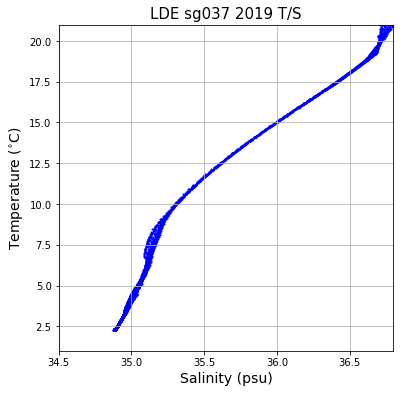

()

In [99]:
f, ax = plt.subplots()
for i in range(np.shape(sa)[1]):
    ax.scatter(s[:, i], t[:, i], s=1, color='b')    
ax.set_xlabel('Salinity (psu)', fontsize=14)
ax.set_ylabel('Temperature ($^{\circ}$C)', fontsize=14)
ax.set_title('LDE sg037 2019 T/S', fontsize=15)
ax.set_xlim([34.5, 36.8])
ax.set_ylim([1, 21])
plot_pro(ax)

In [100]:
# -- Background density profiles and (seasonal variability, not yet for 37) 
# Season Boundaries 
# bd1 = 735750  # (time_rec_bin < bd1) & 
# bd2 = 735856  # 

# split to account for horizontal gradients (should split for onshore/offshore of bermuda)
lon_lim = -69.5  # mid_split in lon
lat_lim = 31.0   # mid_split in lat 
# four boxes will be top left to bottom right clockwise 

# Winter 
d_1 = np.where((np.nanmean(lon, axis=0) < lon_lim) & ((np.nanmean(lat, axis=0) > lat_lim)))[0]
d_2 = np.where((np.nanmean(lon, axis=0) > lon_lim) & ((np.nanmean(lat, axis=0) > lat_lim)))[0]
d_3 = np.where((np.nanmean(lon, axis=0) > lon_lim) & ((np.nanmean(lat, axis=0) < lat_lim)))[0]
d_4 = np.where((np.nanmean(lon, axis=0) < lon_lim) & ((np.nanmean(lat, axis=0) < lat_lim)))[0]

bckgrds = [d_1, d_2, d_3, d_4]
bckgrds_info = ['b_1', 'b_2', 'b_3', 'b_4']

# ABOVE SETS ORDER OF N2 PROFILES (different that order at the end)

salin_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
cons_t_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
theta_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
sigma_theta_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
ddz_avg_sigma = np.nan * np.zeros((len(grid), len(bckgrds)))
N2_0 = np.nan * np.zeros(sigma_theta_avg.shape)
N2_ref = np.nan * np.zeros(sigma_theta_avg.shape)
N = np.nan * np.zeros(sigma_theta_avg.shape)
for i in range(len(bckgrds)):
    inn = bckgrds[i]
    salin_avg[:, i] = np.nanmean(sa[:, inn], axis=1)
    cons_t_avg[:, i] = np.nanmean(ct[:, inn], axis=1)
    theta_avg[:, i] = np.nanmean(theta[:, inn], axis=1)
    sigma_theta_avg[:, i] = np.nanmean(neutral_density[:, inn], axis=1)
    ddz_avg_sigma[:, i] = np.gradient(sigma_theta_avg[:, i], z)
    go = ~np.isnan(salin_avg[:, i])
    N2_0[np.where(go)[0][0:-1], i] = gsw.Nsquared(salin_avg[go, i], cons_t_avg[go, i], grid_p[go], lat=ref_lat)[0]
    N2_0[N2_0[:, i] < 0] = np.nan  # 1 * 10**-7
    N2_ref[:, i] = nanseg_interp(grid, N2_0[:, i])
    # N2_ref[:, i] = savgol_filter(N2_ref[:, i], 5, 3)
N2_ref[-1, :] = N2_ref[-2, :] - 1 * 10**-9
N2 = N2_ref.copy()

N2_all = np.nan * np.zeros(len(grid))
N2_all[0:-1] = gsw.Nsquared(np.nanmean(salin_avg, axis=1), np.nanmean(cons_t_avg, axis=1), grid_p, lat=ref_lat)[0]
N2_all[-2:] = N2_all[-3]
N2_all[N2_all < 0] = np.nan
N2_all = nanseg_interp(grid, N2_all)
N_all = np.sqrt(N2_all)
N2_all = savgol_filter(N2_all, 5, 3)
N2_all[N2_all < 0] = np.nan
N2_all = nanseg_interp(grid, N2_all)

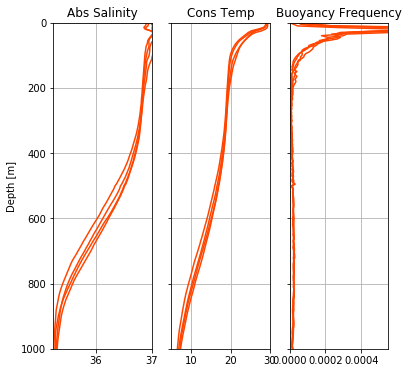

()

In [101]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
coli = '#FF4500', '#FF4500', '#FF4500', '#FF4500', '#2F4F4F', '#2F4F4F', '#2F4F4F', '#2F4F4F', '#DAA520', '#DAA520', '#DAA520', '#DAA520'
# cols = ['#2F4F4F', '#FF4500', '#DAA520']
# season_labs = ['Feb-Apr', 'May-Sept', 'Sept-Nov']
for i in range(len(bckgrds)):
    ax1.plot(salin_avg[:, i], grid, color=coli[i])
    ax2.plot(cons_t_avg[:, i], grid, color=coli[i])
    ax3.plot(N2_ref[:, i], grid, color=coli[i])
ax1.set_ylim([0, 1000])
ax1.grid()
ax2.grid()
ax1.invert_yaxis()
ax1.set_xlim([35.25, 37])
ax1.set_ylabel('Depth [m]')
ax1.set_title('Abs Salinity')
ax2.set_xlim([5, 30])
ax2.set_title('Cons Temp')
ax3.set_xlim([0, 0.00055])
ax3.set_title('Buoyancy Frequency')
plot_pro(ax3)

In [102]:
# -- compute M/W sections and compute velocity
# -- USING X.TRANSECT_CROSS_SECTION_1 (THIS WILL SEPARATE TRANSECTS BY TARGET OF EACH DIVE)
sigth_levels = np.concatenate(
    [np.arange(23, 26.5, 0.5), np.arange(26.2, 27.2, 0.2),
     np.arange(27.2, 27.7, 0.2), np.arange(27.7, 28, 0.02), np.arange(28, 28.15, 0.01)])
# sigth_levels = np.concatenate([np.aranger(32, 36.6, 0.2), np.arange(36.6, 36.8, 0.05), np.arange(36.8, 37.4, 0.02)])

# --- SAVE so that we dont have to run transects every time
savee = 1
if savee > 0:
    ds, dist, avg_ct_per_dep_0, avg_sa_per_dep_0, avg_sig0_per_dep_0, v_g, vbt, \
        isopycdep, isopycx, mwe_lon, mwe_lat, DACe_MW, DACn_MW, profile_tags_per, \
            shear, box_side, v_g_east, v_g_north = x.transect_cross_section_1(grid, neutral_density, 
                                                                               ct, sa, lon, lat,
                                                                               dac_u, dac_v,
                                                                               profile_tags,
                                                                               sigth_levels, bbi)
    my_dict = {'ds': ds, 'dist': dist, 'avg_ct_per_dep_0': avg_ct_per_dep_0,
               'avg_sa_per_dep_0': avg_sa_per_dep_0, 'avg_sig0_per_dep_0': avg_sig0_per_dep_0, 'v_g': v_g, 'vbt': vbt,
               'isopycdep': isopycdep, 'isopycx': isopycx, 'mwe_lon': mwe_lon, 'mwe_lat': mwe_lat, 'DACe_MW': DACe_MW,
               'DACn_MW': DACn_MW, 'profile_tags_per': profile_tags_per, 
               'v_g_east': v_g_east, 'v_g_north': v_g_north, 'box_side': box_side}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg037_2019_transects_test.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()
else:
    pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg037_2019_transects_test.pkl', 'rb')
    B15 = pickle.load(pkl_file)
    pkl_file.close()
    ds = B15['ds']
    dist = B15['dist']
    avg_ct_per_dep_0 = B15['avg_ct_per_dep_0']
    avg_sa_per_dep_0 = B15['avg_sa_per_dep_0']
    avg_sig0_per_dep_0 = B15['avg_sig0_per_dep_0']
    v_g = B15['v_g']
    v_g_east = B15['v_g_east']
    v_g_north = B15['v_g_north']
    box_side = B15['box_side']
    vbt = B15['vbt']
    isopycdep = B15['isopycdep']
    isopycx = B15['isopycx']
    mwe_lon = B15['mwe_lon']
    mwe_lat = B15['mwe_lat']
    DACe_MW = B15['DACe_MW']
    DACn_MW = B15['DACn_MW']
    profile_tags_per = B15['profile_tags_per']

# unpack velocity profiles from transect analysis
dace_mw_0 = DACe_MW[0][0:-1].copy()
dacn_mw_0 = DACn_MW[0][0:-1].copy()
dg_v_0 = v_g[0][:, 0:-1].copy()
dg_v_e_0 = v_g_east[0][:, 0:-1].copy()
dg_v_n_0 = v_g_north[0][:, 0:-1].copy()
avg_sig0_per_dep = avg_sig0_per_dep_0[0].copy()
avg_ct_per_dep = avg_ct_per_dep_0[0].copy()
avg_sa_per_dep = avg_sa_per_dep_0[0].copy()
dg_v_lon = mwe_lon[0][0:-1].copy()
dg_v_lat = mwe_lat[0][0:-1].copy()
dg_v_dive_no_0 = profile_tags_per[0][0:-1].copy()
box_side_0 = box_side[0] * np.ones((1, len(v_g[0][10, 0:-1])))
for i in range(1, len(v_g)):
    dace_mw_0 = np.concatenate((dace_mw_0, DACe_MW[i][0:-1]), axis=0)
    dacn_mw_0 = np.concatenate((dacn_mw_0, DACn_MW[i][0:-1]), axis=0)
    dg_v_0 = np.concatenate((dg_v_0, v_g[i][:, 0:-1]), axis=1)
    dg_v_e_0 = np.concatenate((dg_v_e_0, v_g_east[i][:, 0:-1]), axis=1)
    dg_v_n_0 = np.concatenate((dg_v_n_0, v_g_north[i][:, 0:-1]), axis=1)
    avg_ct_per_dep = np.concatenate((avg_ct_per_dep, avg_ct_per_dep_0[i]), axis=1)
    avg_sa_per_dep = np.concatenate((avg_sa_per_dep, avg_sa_per_dep_0[i]), axis=1)
    avg_sig0_per_dep = np.concatenate((avg_sig0_per_dep, avg_sig0_per_dep_0[i]), axis=1)
    dg_v_lon = np.concatenate((dg_v_lon, mwe_lon[i][0:-1]))
    dg_v_lat = np.concatenate((dg_v_lat, mwe_lat[i][0:-1]))
    dg_v_dive_no_0 = np.concatenate((dg_v_dive_no_0, profile_tags_per[i][0:-1]))
    box_side_0 = np.concatenate((box_side_0, box_side[i] * np.ones((1, len(v_g[i][10, 0:-1])))), axis=1)
    

# Time matching to eta/v profiles
count = 0
for i in range(0, len(profile_tags_per)):
    these_dives = profile_tags_per[i]
    for j in range(len(these_dives) - 1):
        tin = time_rec_bin[np.in1d(profile_tags, these_dives[j:j+2])]
        if count < 1:
            dg_mw_time_0 = np.array([np.nanmean(tin)])
        else:
            dg_mw_time_0 = np.concatenate((dg_mw_time_0, np.array([np.nanmean(tin)])))
        count = count + 1
        
prof_lon_i = np.nanmean(lon, axis=0)
prof_lat_i = np.nanmean(lat, axis=0)     

transects = [[9, 10, 11]]
[9, 10, 11]
index_start = 18
index_end = 24
dive cycles in this transect = [ 55.   55.5  56.   56.5  57.   57.5]


/Users/jake/Documents/geostrophic_turbulence/glider_cross_section.py:678: RuntimeWarning: Mean of empty slice
  info[1, i] = np.nanmean(lon_pa_M)
/Users/jake/Documents/geostrophic_turbulence/glider_cross_section.py:679: RuntimeWarning: Mean of empty slice
  info[2, i] = np.nanmean(lat_pa_M)


profile # = [ 55.   55.5  56.   56.5  57. ]
transects = [[0, 1, 2]]
[0, 1, 2]
index_start = 0
index_end = 6
dive cycles in this transect = [ 46.   46.5  47.   47.5  48.   48.5]
profile # = [ 46.   46.5  47.   47.5  48. ]
transects = [[6, 7, 8]]
[6, 7, 8]
index_start = 12
index_end = 18
dive cycles in this transect = [ 52.   52.5  53.   53.5  54.   54.5]
profile # = [ 52.   52.5  53.   53.5  54. ]
transects = [[3, 4, 5]]
[3, 4, 5]
index_start = 6
index_end = 12
dive cycles in this transect = [ 49.   49.5  50.   50.5  51.   51.5]
profile # = [ 49.   49.5  50.   50.5  51. ]


In [42]:
box_side_0

array([[ 3.,  3.,  3.,  3.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.]])

In [11]:
# successfully split box pattern into segments
# need to look at velocities into/out of box (try for exchange)
# need orientation (+ velocity to port, unique to ACW direction)
# look at velocity structure u vs. v (anisotropy?), spectra for each 

[3.0, 0.0, 0.0, 2.0, 1.0]

In [103]:
# for now average all profiles
salin_avg = np.nanmean(salin_avg, axis=1)
cons_t_avg = np.nanmean(cons_t_avg, axis=1)
theta_avg = np.nanmean(theta_avg, axis=1)
sigma_theta_avg = np.nanmean(sigma_theta_avg, axis=1)
ddz_avg_sigma = np.nanmean(ddz_avg_sigma, axis=1)
N2 = np.nanmean(N2, axis=1)

In [104]:
# Eta from M/W method, which produces an average density per set of profiles
eta_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
eta_alt_2 = np.nan * np.ones(np.shape(avg_sig0_per_dep))
eta_alt_3 = np.nan * np.ones(np.shape(avg_sig0_per_dep))
d_anom_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
gradient_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
for i in range(np.shape(avg_sig0_per_dep)[1]):  # loop over each profile
    # (average of four profiles) - (total long term average, that is seasonal)
    this_time = dg_mw_time_0[i]
    this_lon = dg_v_lon[i]
    this_lat = dg_v_lat[i]
    # match profile with appropriate background (in time and space)

# adjustment for now (not enough profiles for robust background averages)    
#     # first sort by quadrant 
#     # quadrant 1 
#     if (this_lon < lon_lim) & (this_lat > lat_lim): 
#         if this_time < bd1: # winter 
#             t_over = 0  
#         elif (this_time > bd1) & (this_time < bd2):  # summer 
#             t_over = 4  
#         else:  # fall 
#             t_over = 8  
#     # quadrant 2        
#     elif (this_lon > lon_lim) & (this_lat > lat_lim):  
#         if this_time < bd1: # winter 
#             t_over = 1  
#         elif (this_time > bd1) & (this_time < bd2):  # summer 
#             t_over = 5  
#         else:  # fall 
#             t_over = 9      
#     # quadrant 3        
#     elif (this_lon > lon_lim) & (this_lat < lat_lim):
#         if this_time < bd1: # winter 
#             t_over = 2  
#         elif (this_time > bd1) & (this_time < bd2):  # summer 
#             t_over = 6  
#         else:  # fall 
#             t_over = 10  
#     # quadrant 4        
#     else:
#         if this_time < bd1: # winter 
#             t_over = 3 
#         elif (this_time > bd1) & (this_time < bd2):  # summer 
#             t_over = 7  
#         else:  # fall 
#             t_over = 11  

    # ETA ALT (avg_sig0_per_dep and sigma_theta_avg are really neutral density, imported from matlab binning)
    # match profile (really avg of 3/4 profiles) with one of 4 seasonal background profiles
# adjustment for now because we only have one background profile     
#     this_sigma_theta_avg = sigma_theta_avg[:, t_over]
#     eta_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg[:, t_over]) / np.squeeze(ddz_avg_sigma[:, t_over])
#     d_anom_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg[:, t_over])    
    this_sigma_theta_avg = sigma_theta_avg
    eta_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg) / np.squeeze(ddz_avg_sigma)
    d_anom_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg)  
            
    # ETA ALT 2
    # find appropriate average background profiles
    avg_a_salin = salin_avg  # [:, t_over]
    avg_c_temp = cons_t_avg  # [:, t_over]

    # compute density at every depth for every profile using sa and ct profiles (really avg of 3/4 profiles)
    # eta_alt_2 is compute using a local reference pressure
    # loop over each bin depth
    for j in range(2, len(grid) - 2):
        if ~np.isnan(avg_sa_per_dep[j, i]):
            # profile density at depth j with local reference pressure (call p2)
            this_sigma = gsw.rho(avg_sa_per_dep[j, i], avg_ct_per_dep[j, i], grid_p[j]) - 1000      # profile density
            # background density at points above and below p2 with local reference pressure (p2)
            this_sigma_avg = gsw.rho(avg_a_salin[j-2:j+3], avg_c_temp[j-2:j+3], grid_p[j]) - 1000
            d_anom_alt[j, i] = this_sigma - this_sigma_avg[1]
            gradient_alt[j, i] = np.nanmean(np.gradient(this_sigma_avg, z[j-2:j+3]))
            # gradient_alt[j, i] = (this_sigma_avg[0] - this_sigma_avg[2]) / (grid[j-1] - grid[j+1])
            eta_alt_2[j, i] = d_anom_alt[j, i] / gradient_alt[j, i]

    # ETA ALT 3
    for j in range(len(grid)):
        # find this profile density at j along avg profile
        idx, rho_idx = find_nearest(this_sigma_theta_avg, avg_sig0_per_dep[j, i])
        if idx <= 2:
            z_rho_1 = grid[0:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep[j, i], this_sigma_theta_avg[0:idx + 3], z_rho_1) - grid[j]
        else:
            z_rho_1 = grid[idx - 2:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep[j, i], this_sigma_theta_avg[idx - 2:idx + 3], z_rho_1) - grid[j]

# eta_alt = gamma / ddz 
# eta_alt_2 = local potential density / local ddz 
# eta_alt_3 = direct search for gamma on background profile (difference in depths then computed)
eta_alt_0 = eta_alt.copy()

In [105]:
# --- ETA COMPUTED FROM INDIVIDUAL DENSITY PROFILES (AND PE from function)
G_all, Gz_all, c_all, epsilon_all = vertical_modes(N2_all, grid, omega, mmax)
eta_per_prof = np.nan * np.ones(sig2.shape)
eta_per_prof_3 = np.nan * np.ones(sig2.shape)
d_anom_prof = np.nan * np.ones(sig2.shape)
Eta_m_prof = np.nan * np.zeros(np.shape(eta_per_prof_3))
PE_per_mass_prof = np.nan * np.zeros([nmodes, np.shape(eta_per_prof_3)[1]])
for i in range(lon.shape[1]):
    this_lon = np.nanmean(lon[:, i])
    this_lat = np.nanmean(lat[:, i])
    this_time = np.nanmean(d_time[:, i])    
    
#     # first sort by quadrant 
#     # quadrant 1 
#     if (this_lon < lon_lim) & (this_lat > lat_lim): 
#         if this_time < bd1: # winter 
#             t_over = 0  
#         elif (this_time > bd1) & (this_time < bd2):  # summer 
#             t_over = 4  
#         else:  # fall 
#             t_over = 8  
#     # quadrant 2        
#     elif (this_lon > lon_lim) & (this_lat > lat_lim):  
#         if this_time < bd1: # winter 
#             t_over = 1  
#         elif (this_time > bd1) & (this_time < bd2):  # summer 
#             t_over = 5  
#         else:  # fall 
#             t_over = 9      
#     # quadrant 3        
#     elif (this_lon > lon_lim) & (this_lat < lat_lim):
#         if this_time < bd1: # winter 
#             t_over = 2  
#         elif (this_time > bd1) & (this_time < bd2):  # summer 
#             t_over = 6  
#         else:  # fall 
#             t_over = 10  
#     # quadrant 4        
#     else:
#         if this_time < bd1: # winter 
#             t_over = 3 
#         elif (this_time > bd1) & (this_time < bd2):  # summer 
#             t_over = 7  
#         else:  # fall 
#             t_over = 11  

#     this_sigma_theta_avg = sigma_theta_avg[:, t_over]
#     eta_per_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg[:, t_over]) / np.squeeze(ddz_avg_sigma[:, t_over])
#     d_anom_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg[:, t_over])
    this_sigma_theta_avg = sigma_theta_avg
    eta_per_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg) / np.squeeze(ddz_avg_sigma)
    d_anom_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg)
    
    # ETA ALT 3
    # try a new way to compute vertical displacement
    for j in range(len(grid)):
        # find this profile density at j along avg profile
        idx, rho_idx = find_nearest(this_sigma_theta_avg, neutral_density[j, i])
        if idx <= 2:
            z_rho_1 = grid[0:idx + 3]
            eta_per_prof_3[j, i] = np.interp(neutral_density[j, i], this_sigma_theta_avg[0:idx + 3],
                                             z_rho_1) - grid[j]
        else:
            z_rho_1 = grid[idx - 2:idx + 3]
            eta_per_prof_3[j, i] = np.interp(neutral_density[j, i], this_sigma_theta_avg[idx - 2:idx + 3],
                                             z_rho_1) - grid[j]
         
    N2_each = N2  # [:, t_over].copy()            
    n2nan = np.where(np.isnan(N2_each))[0]
    for nn in n2nan:
        N2_each[nn] = N2_each[nn - 1] - 0.000000001
    G_this, Gz_this, c_this, epsilon_this = vertical_modes(N2_each, grid, omega, mmax)
    
    this_eta = eta_per_prof_3[:, i].copy()
    bvf = np.sqrt(N2_each)
    Neta = np.nan * np.zeros(np.shape(this_eta))
    NEta_m = np.nan * np.zeros(np.shape(this_eta))
    AG_prof = np.zeros([nmodes, 1])
    eta_fs = this_eta.copy()  # ETA
    # obtain matrix of NEta
    # old, Neta[:, i] = bvf * this_eta
    # find indices within fitting range
    iw = np.where((grid >= eta_fit_depth_min) & (grid <= eta_fit_depth_max))[0]
    if iw.size > 1:
        i_sh = np.where((grid < eta_fit_depth_min))
        eta_fs[i_sh[0]] = grid[i_sh] * this_eta[iw[0]] / grid[iw[0]]

        # i_dp = np.where((grid > eta_fit_dep_max))
        # eta_fs[i_dp[0]] = (grid[i_dp] - grid[-1]) * this_eta[iw[0][-1]] / (grid[iw[0][-1]] - grid[-1])
        # -- taper fit as z approaches -H
        i_dp = np.where((grid > eta_fit_depth_max))[0]
        lgs = grid[iw[-1]]
        grid_ar = np.nan * np.ones(len(i_dp))
        for oo in range(len(grid[i_dp])):
            grid_ar[oo] = np.int(grid[i_dp[oo]])
        eta_fs[i_dp] = (grid_ar - np.int(grid[-1])) * this_eta[iw[-1]] / (np.int(lgs) - grid[-1])

        AG_prof[1:, 0] = np.squeeze(np.linalg.lstsq(G_this[:, 1:], eta_fs)[0])
        # AG[1:, i] = np.squeeze(np.linalg.lstsq(G[:, 1:], np.transpose(np.atleast_2d(eta_fs)))[0])
        NEta_m = bvf * np.array(np.squeeze(np.matrix(G_this) * np.transpose(np.matrix(AG_prof[:, 0]))))
        Eta_m_prof[:, i] = np.squeeze(np.matrix(G_this) * np.transpose(np.matrix(AG_prof[:, 0])))
        PE_per_mass_prof[:, i] = 0.5 * AG_prof[:, 0] * AG_prof[:, 0] * c_this * c_this

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [106]:
PE_per_mass_all = PE_per_mass_prof.copy()
PE_all_time = np.nanmean(d_time, axis=0)
PE_all_tags = profile_tags.copy()

In [107]:
# look at u,v 
# box completed in clockwise pattern 
# positive velocity is to port of glider 
#
#     ___2____
#    |       |
#    |       |
#   1|       |3 
#    |_______|
#        0 
#
u = np.concatenate([-1.0 * dg_v_0[:, box_side_0[0,:] == 1], dg_v_0[:, box_side_0[0,:] == 3]], axis=1)
v = np.concatenate([-1.0 * dg_v_0[:, box_side_0[0,:] == 0], dg_v_0[:, box_side_0[0,:] == 2]], axis=1)

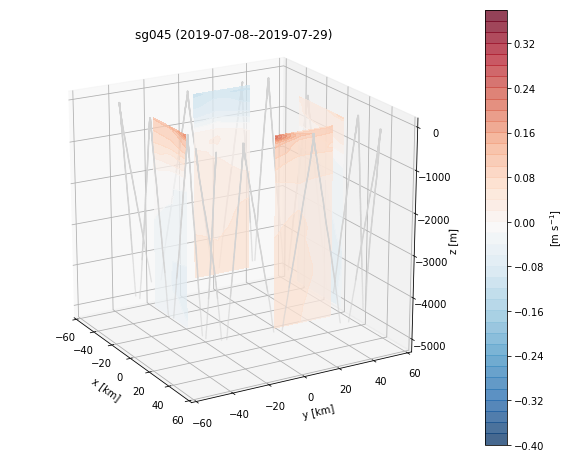

In [108]:
ref_lat = 31.0
ref_lon = -69.5
x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (dg_v_lon - ref_lon)
y = 1852 * 60 * (dg_v_lat - ref_lat)
x_d = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (lon - ref_lon)
y_d = 1852 * 60 * (lat - ref_lat)

u_1 = -1.0 * dg_v_0[:, box_side_0[0,:] == 1]
u_3 = 1.0 * dg_v_0[:, box_side_0[0,:] == 3]
v_0 = -1.0 * dg_v_0[:, box_side_0[0,:] == 0]
v_2 = 1.0 * dg_v_0[:, box_side_0[0,:] == 2]

yy = y[box_side_0[0,:] == 1][1:-1]
uu_1 = u_1[:, 1:-1]

yy_3 = y[box_side_0[0,:] == 3][1:-1]
uu_3 = u_3[:, 1:-1]

xx = x[box_side_0[0,:] == 0][1:-1]
vv_0 = v_0[:, 1:-1]

xx_2 = x[box_side_0[0,:] == 2][1:-1]
vv_2 = v_2[:, 1:-1]

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
matplotlib.rcParams['figure.figsize'] = (10,8)
fig = plt.figure()
ax = fig.gca(projection='3d')
lvs = np.arange(-.4,.4,.02)

for p in range(np.shape(x_d)[1]):
    ax.scatter3D(x_d[:, p]/1000, y_d[:, p]/1000, -1*grid, s=.5,color='#D3D3D3', zorder=2, zdir='z',linewidth=0.75) 

cset = ax.contourf(np.tile(xx,(len(grid),1))/1000, np.ones(np.shape(vv_0))*vv_0,
                  np.transpose(np.tile(-1*grid,(len(xx),1))), 
                  zdir='y', offset=-40, levels=lvs, cmap=cm.RdBu_r, zorder=0, linewidth=1, alpha=0.75)

cset = ax.contourf(np.tile(xx_2,(len(grid),1))/1000, np.ones(np.shape(vv_2))*vv_2, 
                  np.transpose(np.tile(-1*grid,(len(xx_2),1))), 
                  zdir='y', offset=40, levels=lvs, cmap=cm.RdBu_r, zorder=0, linewidth=1, alpha=0.75)

cset = ax.contourf(np.ones(np.shape(uu_1))*uu_1, np.tile(yy,(len(grid),1))/1000, 
                  np.transpose(np.tile(-1*grid,(len(yy),1))), 
                  zdir='x', offset=-40, levels=lvs, cmap=cm.RdBu_r, zorder=1, linewidth=1, alpha=0.75)

cset = ax.contourf(np.ones(np.shape(uu_3))*uu_3, np.tile(yy,(len(grid),1))/1000, 
                  np.transpose(np.tile(-1*grid,(len(yy),1))), 
                  zdir='x', offset=40, levels=lvs, cmap=cm.RdBu_r, zorder=1, linewidth=1, alpha=0.75)

ax.set_xlim([-60, 60])
ax.set_ylim([-60, 60])
ax.set_zlim([-5200, 100])
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_zlabel('z [m]')
ax.set_title('sg045 (' + str(t_s) + '--' + str(t_e) + ')')
ax.view_init(20,-30)
fig.colorbar(cset, label='[m s$^{-1}$]')
plot_pro(ax)
# fig.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_08_15/sg037_box_1.jpg", dpi=300)

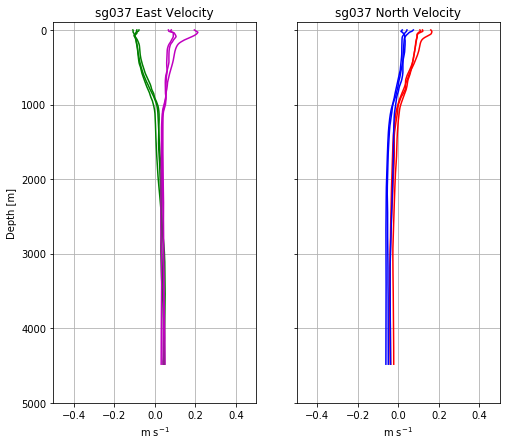

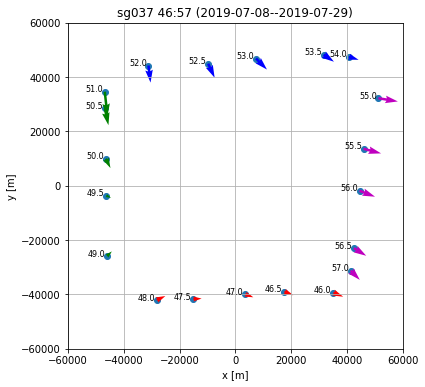

In [109]:
# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
# for i in range(np.shape(u)[1]):
#     if i < np.nansum(box_side_0[0,:] == 1):
#         ax1.plot(u[:, i], grid, color='g')
#     else:
#         ax1.plot(u[:, i], grid, color='m')    
# ax1.set_xlim([-.2, .2])    
# ax1.grid()
# for i in range(np.shape(v)[1]):
#     if i < np.nansum(box_side_0[0,:] == 0):
#         ax2.plot(v[:, i], grid, color='r')
#     else:
#         ax2.plot(v[:, i], grid, color='b')    
# ax2.set_xlim([-.2, .2])     
# ax2.invert_yaxis()    
# plot_pro(ax2)    
matplotlib.rcParams['figure.figsize'] = (8,7)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
for i in range(np.shape(u)[1]):
    if i < np.nansum(box_side_0[0,:] == 1):
        ax1.plot(u[:, i], grid, color='g')
    else:
        ax1.plot(u[:, i], grid, color='m')    
ax1.set_xlim([-.5, .5])   
ax1.set_ylim([-100, 5000])
ax1.set_title('sg037 East Velocity')
ax1.set_xlabel('m s$^{-1}$')
ax1.set_ylabel('Depth [m]')
ax1.grid()
for i in range(np.shape(v)[1]):
    if i < np.nansum(box_side_0[0,:] == 0):
        ax2.plot(v[:, i], grid, color='r')
    else:
        ax2.plot(v[:, i], grid, color='b')    
ax2.set_xlim([-.5, .5])   
ax2.set_title('sg037 North Velocity')
ax2.set_xlabel('m s$^{-1}$')
ax2.invert_yaxis()  
plot_pro(ax2)
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_08_15/sg037_b1_uv.jpg", dpi=300)

matplotlib.rcParams['figure.figsize'] = (6,6)
f, ax3 = plt.subplots()
ax3.scatter(x, y)
for j in range(len(dg_v_dive_no_0)):
    ax3.text(x[j] - 7000, y[j], str(dg_v_dive_no_0[j]), fontsize=8)
ax3.quiver(x[box_side_0[0,:] == 0], y[box_side_0[0,:] == 0], 
          dace_mw_0[box_side_0[0,:] == 0], dacn_mw_0[box_side_0[0,:] == 0], color='r', scale=1)
ax3.quiver(x[box_side_0[0,:] == 2], y[box_side_0[0,:] == 2], 
          dace_mw_0[box_side_0[0,:] == 2], dacn_mw_0[box_side_0[0,:] == 2], color='b', scale=1)
ax3.quiver(x[box_side_0[0,:] == 1], y[box_side_0[0,:] == 1], 
          dace_mw_0[box_side_0[0,:] == 1], dacn_mw_0[box_side_0[0,:] == 1], color='g', scale=1)
ax3.quiver(x[box_side_0[0,:] == 3], y[box_side_0[0,:] == 3], 
          dace_mw_0[box_side_0[0,:] == 3], dacn_mw_0[box_side_0[0,:] == 3], color='m', scale=1)
ax3.set_xlim([-60000, 60000])
ax3.set_ylim([-60000, 60000])
ax3.set_xlabel('x [m]')
ax3.set_ylabel('y [m]')
ax3.set_title('sg037 ' + str(gs) + ':' + str(ge) + ' (' + str(t_s) + '--' + str(t_e) + ')')
plot_pro(ax3)    
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_08_15/sg037_b1_dac.jpg", dpi=300)

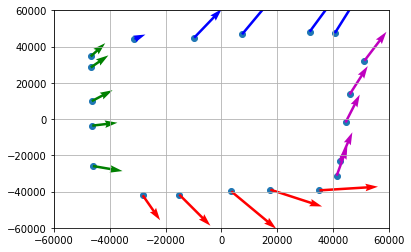

()

In [52]:
x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (dg_v_lon - ref_lon)
y = 1852 * 60 * (dg_v_lat - ref_lat)

f, ax = plt.subplots()
ax.scatter(x, y)
ax.quiver(x[box_side_0[0,:] == 0], y[box_side_0[0,:] == 0], 
          dace_mw_0[box_side_0[0,:] == 0], dacn_mw_0[box_side_0[0,:] == 0], color='r', scale=1)
ax.quiver(x[box_side_0[0,:] == 2], y[box_side_0[0,:] == 2], 
          dace_mw_0[box_side_0[0,:] == 2], dacn_mw_0[box_side_0[0,:] == 2], color='b', scale=1)
ax.quiver(x[box_side_0[0,:] == 1], y[box_side_0[0,:] == 1], 
          dace_mw_0[box_side_0[0,:] == 1], dacn_mw_0[box_side_0[0,:] == 1], color='g', scale=1)
ax.quiver(x[box_side_0[0,:] == 3], y[box_side_0[0,:] == 3], 
          dace_mw_0[box_side_0[0,:] == 3], dacn_mw_0[box_side_0[0,:] == 3], color='m', scale=1)
ax.set_xlim([-60000, 60000])
ax.set_ylim([-60000, 60000])
plot_pro(ax)

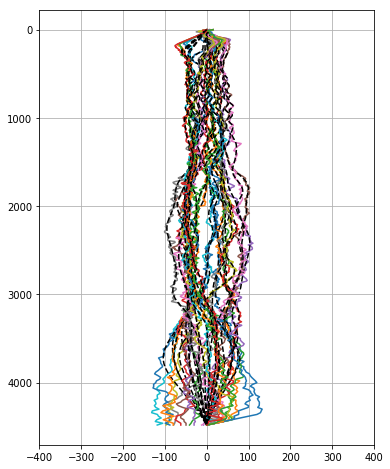

()

In [75]:
matplotlib.rcParams['figure.figsize'] = (6, 8)
f, ax = plt.subplots()
for i in range(np.shape(eta_per_prof_3)[1]):
    ax.plot(eta_per_prof_3[:, i], grid)
    ax.plot(Eta_m_prof[:, i], grid, color='k', linestyle='--')
ax.set_xlim([-400, 400])
ax.invert_yaxis()    
plot_pro(ax)

In [83]:
# FILTER VELOCITY PROFILES IF THEY ARE TOO NOISY / BAD -- ALSO HAVE TO REMOVE EQUIVALENT ETA PROFILE (non-ind profiles)
# select only velocity profiles that seem reasonable
# criteria are slope of v (dont want kinks)
# criteria: limit surface velocity to greater that 40cm/s
good_v = np.zeros(np.shape(dg_v_0)[1], dtype=bool)
for i in range(np.shape(dg_v_0)[1]):
    dv_dz = np.gradient(dg_v_0[20:-20, i], -1 * grid[20:-20])
    print(np.nanmax(np.abs(dv_dz)))
    if (np.nanmax(np.abs(dv_dz)) < 0.01) & (np.nanmax(np.abs(eta_alt_3[20:-20, i])) < 1000):  # 0.0225
        good_v[i] = True
# good_v[np.abs(dg_v_0[5,:]) > 1] = False
        
avg_sig = avg_sig0_per_dep[:, good_v]
eta_alt = eta_alt_3[:, good_v]
dace_mw = dace_mw_0[good_v]
dacn_mw = dacn_mw_0[good_v]
dg_v = dg_v_0[:, good_v]
dg_v_e = dg_v_e_0[:, good_v]
dg_v_n = dg_v_n_0[:, good_v]
dg_mw_time = dg_mw_time_0[good_v]
dg_v_dive_no = dg_v_dive_no_0[good_v]
num_mw_profs = np.shape(eta_alt)[1]

# Smooth DG N2 profiles
dg_avg_N2_coarse = np.nanmean(dg_N2, axis=1)
dg_avg_N2_coarse[np.isnan(dg_avg_N2_coarse)] = dg_avg_N2_coarse[~np.isnan(dg_avg_N2_coarse)][0] - 1*10**(-5)
dg_avg_N2 = savgol_filter(dg_avg_N2_coarse, 15, 3)

nan
0.000904595540176
0.000363984192343
0.000260862327024
nan
nan
0.000593744238914
0.000232534950104
0.00014923010924
nan
nan
0.000113394625621
0.000159275044994
0.000174766749065
nan
nan
0.000201668976891
0.000269899011486
0.000237901465232
nan


/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: All-NaN slice encountered
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: All-NaN slice encountered
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: Mean of empty slice


In [91]:
np.shape(vv_2)

(450, 3)

In [92]:
# SAVING 
savee = 1
if savee > 0:
    my_dict = {'depth': grid, 'raw_profile_tags': profile_tags, 'sa': sa, 'ct': ct, 'gamma': neutral_density, 
               'prof_lon': lon, 'prof_lat': lat,
               'profile_time': time_rec_bin, 'ref_lon': ref_lon, 'ref_lat': ref_lat,  
               'lon_lim': lon_lim, 'lat_lim': lat_lim,
               'N2_by_season_quad': N2, 'bckgrd_sa': salin_avg, 'bckgrd_ct': cons_t_avg,
               'bckgrd_theta': theta_avg, 'bckgrd_gamma': sigma_theta_avg, 'mw_time': dg_mw_time_0, 'mw_lon': prof_lon_i,
               'mw_lat': prof_lat_i, 'mw_ct': avg_ct_per_dep, 'mw_sa': avg_sa_per_dep, 'mw_gamma': avg_sig0_per_dep,
               'eta_1': eta_alt_0, 'eta_2': eta_alt_2, 'eta_3': eta_alt_3, 'eta_per_1': eta_per_prof, 
               'eta_per_3': eta_per_prof_3, 'mw_prof': dg_v_dive_no_0,
               'good_v_ind': good_v, 'mw_time_good': dg_mw_time,
               'mw_gamma_good': avg_sig, 'eta_1_good': eta_alt_0[:, good_v], 'eta_2_good': eta_alt_2[:, good_v],
               'eta_3_good': eta_alt_3[:, good_v], 'dac_e_mw': dace_mw, 'dac_n_mw': dacn_mw,
               'dg_v_good': dg_v, 'dg_v': dg_v_0, 'dg_v_e_good': dg_v_e, 'dg_v_n_good': dg_v_n, 
               'mw_prof_good': dg_v_dive_no, 
               'v_0': vv_0, 'u_1': uu_1, 'v_2': vv_2, 'u_3': uu_3,
               'PE_per_prof': PE_per_mass_all, 'PE_per_prof_time': PE_all_time, 'PE_per_prof_tag': PE_all_tags}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg037_2019_initial_processing.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()
    
    # 'background_indices': bckgrds, 'background key': bckgrds_info, 'bd1': bd1, 'bd2': bd2,